<a href="https://colab.research.google.com/github/google/neural-tangents/blob/master/notebooks/phase_diagram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

### Imports & Utils

In [0]:
!pip install -q git+https://www.github.com/google/neural-tangents

In [0]:
import jax.numpy as np

from jax.experimental import optimizers
from jax.api import grad, jit, vmap
from jax import lax
from jax.config import config
config.update('jax_enable_x64', True)




import neural_tangents as nt
from neural_tangents import stax

_Kernel = nt.utils.kernel.Kernel
M = nt.utils.kernel.Marginalisation

def Kernel(K):
  return _Kernel(var1=np.diag(K), nngp=K, var2=None, 
                 ntk=None, is_gaussian=True, is_height_width=True,
                 marginal=M.OVER_ALL, cross=M.OVER_ALL,
                 shape1=(2, 1024), shape2=(2,1024),
                 x1_is_x2=True, is_input=True) 

In [0]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='white')

def format_plot(x='', y='', grid=True):  
  ax = plt.gca()
    
  plt.grid(grid)
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

# Phase Diagram

Here we will reproduce the phase diagram described in [Poole et al.](https://papers.nips.cc/paper/6322-exponential-expressivity-in-deep-neural-networks-through-transient-chaos) and [Schoenholz et al.](https://arxiv.org/abs/1611.01232) using Neural Tangents. In these and subsequent papers, it was found that deep neural networks can exhibit a phase transition as a function of the variance of their weights ($\sigma_w^2$) and biases ($\sigma_b^2$). For networks with $\tanh$ activation functions, this phase transition is between an "ordered" phase - where pairs of inputs collapse to a single point as they propagate through the network - and a "chaotic" phase - where pairs of inputs diverge as they propagate through the network. This phase diagram is shown below. 

![Phase Diagram](https://github.com/google/neural-tangents/tree/master/notebooks/figures/pennington_phase_diagram.svg?raw=true)

> Phase diagram for $\tanh$ neural networks (appeared in [Pennington et al.](https://arxiv.org/abs/1802.09979)).

Given two inputs to a neural network, $x_1$ and $x_2$, we can compute the cosine-angle between them, $C^0 = \cos\theta_{12} = \frac{x_1^T x_2}{\|x_1\|\|x_2\|}$. Moreover, we can compute the cosine-angle between pairs of pre-activations at any layer of the network and call this $C^l$. For any neural network architecture there is a function, called the $\mathcal{C}$-map, such that $C^{l+1} = \mathcal C(C^l)$. The ordered and chaotic phase are characterized by the asymptotic value $C^* = \lim_{l\to\infty} C^l$. In the ordered phase $C^* = 1$ and in the chaotic phase $C^* < 1$. The phase boundary is defined as the point where $C^* = 1$ is marginally stable and so $\chi_1 = \frac{\partial\mathcal C}{\partial C}\big|_{C=1}$.

\

To reproduce these results in Neural Tangents, we notice first that the $\mathcal{C}$-map described above is intimately related to the NNGP kernel of [Lee et al.](https://arxiv.org/abs/1711.00165) and so Neural Tangents naturally gives a way of computing the $\mathcal{C}$-map for a wide range of network architectures. In particular, given two inputs $C^l$ can be written in terms of the NNGP kernel $K^l$ as $C^l = \frac{K^l_{12}}{\sqrt{K^l_{11} K^l_{22}}}$.

\

To produce results similar to [Poole et al.](https://papers.nips.cc/paper/6322-exponential-expressivity-in-deep-neural-networks-through-transient-chaos), we will use a fully-connected network with $\text{Erf}$ activation functions. To do this, we will first write a function to compute the (asymptotic) fixed-point correlation function by optimizing an objective,

$$L = ||K - \mathcal K(K)||^2$$

where $\mathcal K$ maps the NNGP kernel from one layer to the next. This will require a little bit of hacking into the Neural Tangents internals because we want to feed a kernel directly into the kernel function rather than real inputs.

\

Note: this particular phase diagram holds for a wide range of neural networks but, emphatically, not for ReLUs. The ReLU phase diagram is somewhat different and could be investigated using Neural Tangents. However, we will save it for a followup notebook.

In [0]:
def fixed_point_and_kernel_fn(W_var, b_var, steps, step_size, momentum):
  W_std = np.sqrt(W_var)
  b_std = np.sqrt(b_var)

  # Create a single layer of a network as an affine transformation composed
  # with an Erf nonlinearity.
  kernel_fn = stax.serial(stax.Dense(1024, W_std, b_std), stax.Erf())[2]

  # Define an L2 loss comparing the kernel after applying the layer to the 
  # kernel before. If we have found a fixed point then this kernel will be zero.
  def loss(K):
    return np.sum((K - kernel_fn(Kernel(K)).nngp) ** 2)

  # Create a momentum optimizer.
  init_fn, apply_fn, get_params = optimizers.momentum(step_size, momentum)

  # Start with an initial guess of the covariance matrix.
  K = np.array([[1, 0.1], [0.1, 1]])
  inital_loss = loss(K)
  state = init_fn(K)

  # Define a loop-body that updates the kernel using momentum on our loss.
  def body(i, state):
    K = get_params(state)
    return apply_fn(i, grad(loss)(K), state)
  state = lax.fori_loop(0, steps, body, state)

  K = get_params(state)

  return kernel_fn, K

def fixed_point_correlation(
    W_var, b_var, steps=60000, step_size=0.01, momentum=0.9):
  
  _, K = fixed_point_and_kernel_fn(W_var, b_var, steps, step_size, momentum)

  return K[1, 0] / np.sqrt(K[0, 0] * K[1, 1])

To generate the phase diagram above, we would like to compute the fixed-point correlation not only at a single value of $(\sigma_w^2,\sigma_b^2)$ but on a whole mesh. We can use JAX's `vmap` functionality to do this.

In [0]:
# Vectorize over the weight variance.
fixed_point_correlation = vmap(fixed_point_correlation, (0, None))
# Vectorize over the bias variance.
fixed_point_correlation = vmap(fixed_point_correlation, (None, 0))
# Compile the function.
fixed_point_correlation = jit(fixed_point_correlation)

In [0]:
W_var = np.arange(0, 3, 0.01)
b_var = np.arange(0.01, 0.25, 0.001)

C_star = fixed_point_correlation(W_var, b_var)

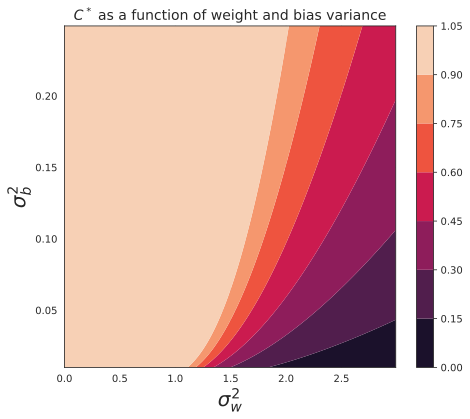

In [66]:
plt.contourf(W_var, b_var, C_star)
plt.colorbar()
plt.title('$C^*$ as a function of weight and bias variance', fontsize=14)

format_plot('$\\sigma_w^2$', '$\\sigma_b^2$')
finalize_plot((1.15, 1))

Here we see that, as expected, $C^* = 1$ above the critical line and $C^* < 1$ below it. We can, of course, threshold on $C^*$ to get a cleaner definition of the phase diagram.

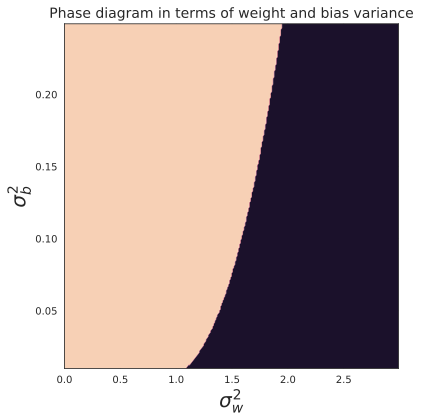

In [67]:
plt.contourf(W_var, b_var, C_star > 0.95)
plt.title('Phase diagram in terms of weight and bias variance', fontsize=14)

format_plot('$\\sigma_w^2$', '$\\sigma_b^2$')
finalize_plot((1, 1))

As described above, the boundary between the two phases should be defined by $\chi_1(\sigma_w^2, \sigma_b^2) = 1$ where $\chi_1$ is given by the derivative of the $\mathcal C$-map. We can use Neural Tangents in combined with JAX's automatic differentiation to easily compute $\chi_1$.

In [0]:
def chi_fn(c, W_var, b_var, steps=60000, step_size=0.01, momentum=0.9):
  kernel_fn, K = fixed_point_and_kernel_fn(
      W_var, b_var, steps, step_size, momentum)
  
  # Decompose the kernel into the variance and the correlation.
  qstar = np.sqrt(K[0, 0] * K[1, 1])

  # Define the C-map.
  def c_map(c):
    K_c = np.array([[qstar, qstar * c], [qstar * c, qstar]])
    K_cp = kernel_fn(Kernel(K_c)).nngp
    return K_cp[0, 1] / np.sqrt(K_cp[0, 0] * K_cp[1, 1])

  # Compute \chi_1 as the derivative of the C-map.
  return grad(c_map)(c)

# Vectorize over the weight variance.
chi_fn = vmap(chi_fn, (None, 0, None))
# Vectorize over the bias variance.
chi_fn = vmap(chi_fn, (None, None, 0))
# Compile the function.
chi_fn = jit(chi_fn)

In [0]:
chi_1 = chi_fn(1.0, W_var, b_var)

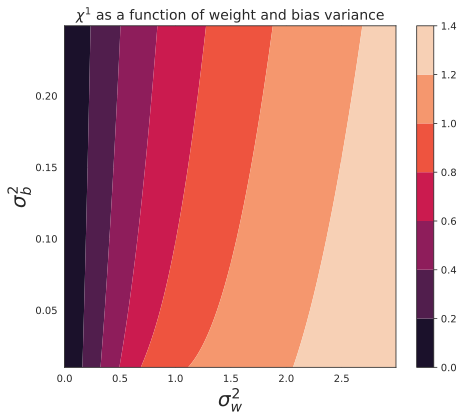

In [70]:
plt.contourf(W_var, b_var, chi_1)
plt.colorbar()
plt.title(r'$\chi^1$ as a function of weight and bias variance', fontsize=14)

format_plot('$\\sigma_w^2$', '$\\sigma_b^2$')
finalize_plot((1.15, 1))

We can see that the boundary where $\chi_1$ crosses 1 corresponds to the phase boundary we observe above.

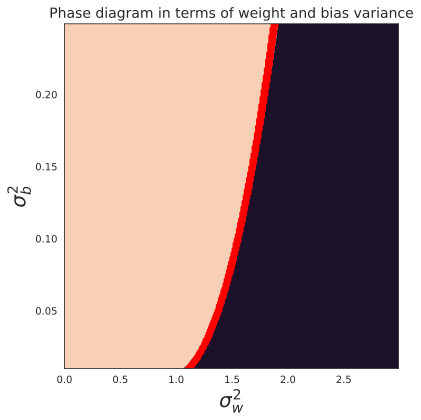

In [89]:
plt.contourf(W_var, b_var, C_star > 0.97)
plt.contourf(W_var, b_var, np.array(np.abs(chi_1 - 1) < 0.01, np.float32), 
             levels=[0.5, 1], colors=[[1, 0, 0]])

plt.title('Phase diagram in terms of weight and bias variance', fontsize=14)

format_plot('$\\sigma_w^2$', '$\\sigma_b^2$')
finalize_plot((1, 1))